In [358]:
import pandas as pd
import numpy as np
import polars as pl

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
import seaborn as sns

import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *

SEED = 42
n_splits = 5

In [359]:
warnings.filterwarnings('ignore', category=FutureWarning)

sns.set(style="whitegrid")
%matplotlib inline

In [360]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data_dict = pd.read_csv('data_dictionary.csv')

In [361]:
def calculate_stats(data, columns):
    if isinstance(columns, str):
        columns = [columns]

    stats = []
    for col in columns:
        if data[col].dtype in ['object', 'category']:
            counts = data[col].value_counts(dropna=False, sort=False)
            percents = data[col].value_counts(normalize=True, dropna=False, sort=False) * 100
            formatted = counts.astype(str) + ' (' + percents.round(2).astype(str) + '%)'
            stats_col = pd.DataFrame({'count (%)': formatted})
            stats.append(stats_col)
        else:
            stats_col = data[col].describe().to_frame().transpose()
            stats_col['missing'] = data[col].isnull().sum()
            stats_col.index.name = col
            stats.append(stats_col)

    return pd.concat(stats, axis=0)

In [362]:
train_cols = set(train.columns)
test_cols = set(test.columns)
columns_not_in_test = sorted(list(train_cols - test_cols))
data_dict[data_dict['Field'].isin(columns_not_in_test)]

,Instrument,Field,Description,Type,Values,Value Labels
54,Parent-Child Internet Addiction Test,PCIAT-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
55,Parent-Child Internet Addiction Test,PCIAT-PCIAT_01,How often does your child disobey time limits ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
56,Parent-Child Internet Addiction Test,PCIAT-PCIAT_02,How often does your child neglect household ch...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
57,Parent-Child Internet Addiction Test,PCIAT-PCIAT_03,How often does your child prefer to spend time...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
58,Parent-Child Internet Addiction Test,PCIAT-PCIAT_04,How often does your child form new relationshi...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
59,Parent-Child Internet Addiction Test,PCIAT-PCIAT_05,How often do you complain about the amount of ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
60,Parent-Child Internet Addiction Test,PCIAT-PCIAT_06,How often do your child's grades suffer becaus...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
61,Parent-Child Internet Addiction Test,PCIAT-PCIAT_07,How often does your child check his or her e-m...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
62,Parent-Child Internet Addiction Test,PCIAT-PCIAT_08,How often does your child seem withdrawn from ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
63,Parent-Child Internet Addiction Test,PCIAT-PCIAT_09,How often does your child become defensive or ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."


In [363]:
pciat_min_max = train.groupby('sii')['PCIAT-PCIAT_Total'].agg(['min', 'max'])
pciat_min_max = pciat_min_max.rename(
    columns={'min': 'Minimum PCIAT total Score', 'max': 'Maximum total PCIAT Score'}
)
pciat_min_max

,Minimum PCIAT total Score,Maximum total PCIAT Score
sii,,
0.0,0.0,30.0
1.0,31.0,49.0
2.0,50.0,79.0
3.0,80.0,93.0


In [364]:
data_dict[data_dict['Field'] == 'PCIAT-PCIAT_Total']['Value Labels'].iloc[0]

'Severity Impairment Index: 0-30=None; 31-49=Mild; 50-79=Moderate; 80-100=Severe'

In [365]:
train_with_sii = train[train['sii'].notna()][columns_not_in_test]
train_with_sii[train_with_sii.isna().any(axis=1)].head().style.applymap(
    lambda x: 'background-color: #FFC0CB' if pd.isna(x) else ''
)

,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,PCIAT-Season,sii
24,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,nan,2.000000,30.000000,Summer,0.000000
93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,Fall,0.000000
104,5.000000,2.000000,4.000000,2.000000,nan,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,45.000000,Fall,1.000000
141,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,nan,0.000000,2.000000,0.000000,26.000000,Winter,0.000000
142,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,26.000000,Spring,0.000000


In [366]:
PCIAT_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]
recalc_total_score = train_with_sii[PCIAT_cols].sum(
    axis=1, skipna=True
)
(recalc_total_score == train_with_sii['PCIAT-PCIAT_Total']).all()

True

In [367]:
def recalculate_sii(row):
    if pd.isna(row['PCIAT-PCIAT_Total']):
        return np.nan
    max_possible = row['PCIAT-PCIAT_Total'] + row[PCIAT_cols].isna().sum() * 5
    if row['PCIAT-PCIAT_Total'] <= 30 and max_possible <= 30:
        return 0
    elif 31 <= row['PCIAT-PCIAT_Total'] <= 49 and max_possible <= 49:
        return 1
    elif 50 <= row['PCIAT-PCIAT_Total'] <= 79 and max_possible <= 79:
        return 2
    elif row['PCIAT-PCIAT_Total'] >= 80 and max_possible >= 80:
        return 3
    return np.nan

train['recalc_sii'] = train.apply(recalculate_sii, axis=1)

In [368]:
mismatch_rows = train[
    (train['recalc_sii'] != train['sii']) & train['sii'].notna()
]

mismatch_rows[PCIAT_cols + [
    'PCIAT-PCIAT_Total', 'sii', 'recalc_sii'
]].style.applymap(
    lambda x: 'background-color: #FFC0CB' if pd.isna(x) else ''
)

,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,sii,recalc_sii
24,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,nan,2.000000,30.000000,0.000000,nan
93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,nan
104,5.000000,2.000000,4.000000,2.000000,nan,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,45.000000,1.000000,nan
141,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,nan,0.000000,2.000000,0.000000,26.000000,0.000000,nan
142,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,26.000000,0.000000,nan
270,3.000000,3.000000,4.000000,2.000000,4.000000,2.000000,1.000000,3.000000,2.000000,2.000000,4.000000,0.000000,2.000000,1.000000,4.000000,nan,2.000000,3.000000,4.000000,2.000000,48.000000,1.000000,nan
368,2.000000,3.000000,4.000000,2.000000,5.000000,1.000000,2.000000,nan,nan,nan,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,nan,nan,31.000000,1.000000,nan
592,3.000000,0.000000,3.000000,0.000000,3.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000,nan,nan,1.000000,2.000000,1.000000,1.000000,0.000000,21.000000,0.000000,nan
724,3.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,nan,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,1.000000,29.000000,0.000000,nan
877,5.000000,5.000000,5.000000,4.000000,5.000000,0.000000,5.000000,5.000000,5.000000,5.000000,4.000000,nan,4.000000,5.000000,5.000000,1.000000,5.000000,0.000000,5.000000,5.000000,78.000000,2.000000,nan


In [369]:
train['sii'] = train['recalc_sii']
train['complete_resp_total'] = train['PCIAT-PCIAT_Total'].where(
    train[PCIAT_cols].notna().all(axis=1), np.nan
)

sii_map = {0: '0 (None)', 1: '1 (Mild)', 2: '2 (Moderate)', 3: '3 (Severe)'}
train['sii'] = train['sii'].map(sii_map).fillna('Missing')

sii_order = ['Missing', '0 (None)', '1 (Mild)', '2 (Moderate)', '3 (Severe)']
train['sii'] = pd.Categorical(train['sii'], categories=sii_order, ordered=True)

train.drop(columns='recalc_sii', inplace=True)

In [370]:
param_map = {0: '< 1h/day', 1: '~ 1h/day', 2: '~ 2hs/day', 3: '> 3hs/day'}
train['internet_use_encoded'] = train[
    'PreInt_EduHx-computerinternet_hoursday'
].map(param_map).fillna('Missing')

param_ord = ['Missing', '< 1h/day', '~ 1h/day', '~ 2hs/day', '> 3hs/day']
train['internet_use_encoded'] = pd.Categorical(
    train['internet_use_encoded'], categories=param_ord,
    ordered=True
)

In [371]:
season_columns = [col for col in train.columns if 'Season' in col]
season_df = train[season_columns]
season_df
train[season_columns] = train[season_columns].fillna("Missing")

In [372]:
data_dict = data_dict[data_dict['Instrument'] != 'Parent-Child Internet Addiction Test']
continuous_cols = data_dict[data_dict['Type'].str.contains(
    'float|int', case=False
)]['Field'].tolist()

In [373]:
train.loc[train['CGAS-CGAS_Score'] == 999, 'CGAS-CGAS_Score'] = np.nan

In [374]:
bins = np.arange(0, 101, 10)
labels = [
    "1-10: Needs constant supervision (24 hour care)",
    "11-20: Needs considerable supervision",
    "21-30: Unable to function in almost all areas",
    "31-40: Major impairment in functioning in several areas",
    "41-50: Moderate degree of interference in functioning",
    "51-60: Variable functioning with sporadic difficulties",
    "61-70: Some difficulty in a single area",
    "71-80: No more than slight impairment in functioning",
    "81-90: Good functioning in all areas",
    "91-100: Superior functioning"
]

train['CGAS_Score_Bin'] = pd.cut(
    train['CGAS-CGAS_Score'], bins=bins, labels=labels
)

counts = train['CGAS_Score_Bin'].value_counts().reindex(labels)

In [375]:
train_filt = train.dropna(subset=['CGAS_Score_Bin', 'complete_resp_total'])
train_filt.loc[:, 'CGAS_Score_Bin'] = train_filt['CGAS_Score_Bin'].cat.remove_unused_categories()
train_filt.loc[:, 'sii'] = train_filt['sii'].cat.remove_unused_categories()
len(train_filt)

2288

In [376]:
score_min_max = train.groupby('sii')['CGAS-CGAS_Score'].agg(['min', 'max'])
score_min_max = score_min_max.rename(
    columns={'min': 'Minimum CGAS Score', 'max': 'Maximum CGAS Score'}
)
score_min_max

,Minimum CGAS Score,Maximum CGAS Score
sii,,
Missing,40.0,85.0
0 (None),25.0,95.0
1 (Mild),30.0,95.0
2 (Moderate),35.0,85.0
3 (Severe),35.0,80.0


In [377]:
train_filt[train_filt['CGAS-CGAS_Score'] < 35][
    ['Basic_Demos-Age', 'Basic_Demos-Sex', 'sii',
     'CGAS-CGAS_Score',
     'PreInt_EduHx-computerinternet_hoursday']
]

train[train['CGAS-CGAS_Score'] > 90][
    ['Basic_Demos-Age', 'Basic_Demos-Sex', 'sii',
     'CGAS-CGAS_Score',
     'PreInt_EduHx-computerinternet_hoursday']
]

,Basic_Demos-Age,Basic_Demos-Sex,sii,CGAS-CGAS_Score,PreInt_EduHx-computerinternet_hoursday
310,13,1,0 (None),91.0,2.0
591,10,1,0 (None),93.0,NaN
667,13,0,0 (None),95.0,0.0
910,10,1,0 (None),91.0,0.0
1007,14,0,1 (Mild),95.0,0.0
1157,14,1,1 (Mild),91.0,2.0
1640,11,1,0 (None),92.0,0.0
2342,6,1,0 (None),91.0,0.0
2668,14,1,0 (None),92.0,0.0
2675,11,0,0 (None),91.0,0.0


In [378]:
groups = data_dict.groupby('Instrument')['Field'].apply(list).to_dict()
features_physical = groups.get('Physical Measures', [])
cols = [col for col in features_physical if col in continuous_cols]
wh_cols = [
    'Physical-BMI', 'Physical-Height',
    'Physical-Weight', 'Physical-Waist_Circumference'
]
train[wh_cols] = train[wh_cols].replace(0, np.nan)

In [379]:
lbs_to_kg = 0.453592
inches_to_cm = 2.54

train['Physical-Weight'] = train['Physical-Weight'] * lbs_to_kg
train['Physical-Height'] = train['Physical-Height'] * inches_to_cm
train['Physical-Waist_Circumference'] = train['Physical-Waist_Circumference'] * inches_to_cm

# Recalculate BMI: BMI = weight (kg) / (height (m)^2)
train['Physical-BMI'] = np.where(
    train['Physical-Weight'].notna() & train['Physical-Height'].notna(),
    train['Physical-Weight'] / ((train['Physical-Height'] / 100) ** 2),
    np.nan  # If either is NaN, set BMI to NaN
)

calculate_stats(train, wh_cols)

,count,mean,std,min,25%,50%,75%,max,missing
Physical-BMI,3015.0,19.378674,5.034658,8.523273,15.892086,17.952687,21.590750,59.137852,945
Physical-Height,3027.0,142.104651,18.983360,83.820000,127.000000,139.700000,157.480000,199.390000,933
Physical-Weight,3015.0,41.204324,19.577654,14.424226,26.399054,35.289458,51.845566,142.881480,945
Physical-Waist_Circumference,898.0,69.287410,14.140909,45.720000,58.420000,66.040000,76.200000,127.000000,3062


In [380]:
bp_hr_cols = [
    'Physical-Diastolic_BP', 'Physical-Systolic_BP',
    'Physical-HeartRate'
]

train[train['Physical-Systolic_BP'] <= train['Physical-Diastolic_BP']][bp_hr_cols]

,Physical-Diastolic_BP,Physical-Systolic_BP,Physical-HeartRate
1140,179.0,139.0,103.0
1879,117.0,114.0,114.0
2386,76.0,76.0,116.0
3199,0.0,0.0,NaN
3344,98.0,73.0,96.0


In [381]:
train[cols] = train[cols].replace(0, np.nan)
train.loc[train['Physical-Systolic_BP'] <= train['Physical-Diastolic_BP'], bp_hr_cols] = np.nan

In [382]:
bmi_categories = [
    ('Underweight', train['Physical-BMI'] < 18.5),
    ('Normal weight', (train['Physical-BMI'] >= 18.5) & (train['Physical-BMI'] <= 24.9)),
    ('Overweight', (train['Physical-BMI'] >= 25) & (train['Physical-BMI'] <= 29.9)),
    ('Obesity', train['Physical-BMI'] >= 30)
]
bmi_category_counts = {label: condition.sum() for label, condition in bmi_categories}

In [383]:
data_dict[data_dict['Instrument'] == 'Bio-electric Impedance Analysis']

,Instrument,Field,Description,Type,Values,Value Labels
33,Bio-electric Impedance Analysis,BIA-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
34,Bio-electric Impedance Analysis,BIA-BIA_Activity_Level_num,Activity Level,categorical int,"1,2,3,4,5","1=Very Light, 2=Light, 3=Moderate, 4=Heavy, 5=..."
35,Bio-electric Impedance Analysis,BIA-BIA_BMC,Bone Mineral Content,float,NaN,NaN
36,Bio-electric Impedance Analysis,BIA-BIA_BMI,Body Mass Index,float,NaN,NaN
37,Bio-electric Impedance Analysis,BIA-BIA_BMR,Basal Metabolic Rate,float,NaN,NaN
38,Bio-electric Impedance Analysis,BIA-BIA_DEE,Daily Energy Expenditure,float,NaN,NaN
39,Bio-electric Impedance Analysis,BIA-BIA_ECW,Extracellular Water,float,NaN,NaN
40,Bio-electric Impedance Analysis,BIA-BIA_FFM,Fat Free Mass,float,NaN,NaN
41,Bio-electric Impedance Analysis,BIA-BIA_FFMI,Fat Free Mass Index,float,NaN,NaN
42,Bio-electric Impedance Analysis,BIA-BIA_FMI,Fat Mass Index,float,NaN,NaN


In [384]:
bia_data_dict = data_dict[data_dict['Instrument'] == 'Bio-electric Impedance Analysis']
categorical_columns = bia_data_dict[bia_data_dict['Type'] == 'categorical int']['Field'].tolist()
continuous_columns = bia_data_dict[bia_data_dict['Type'] == 'float']['Field'].tolist()

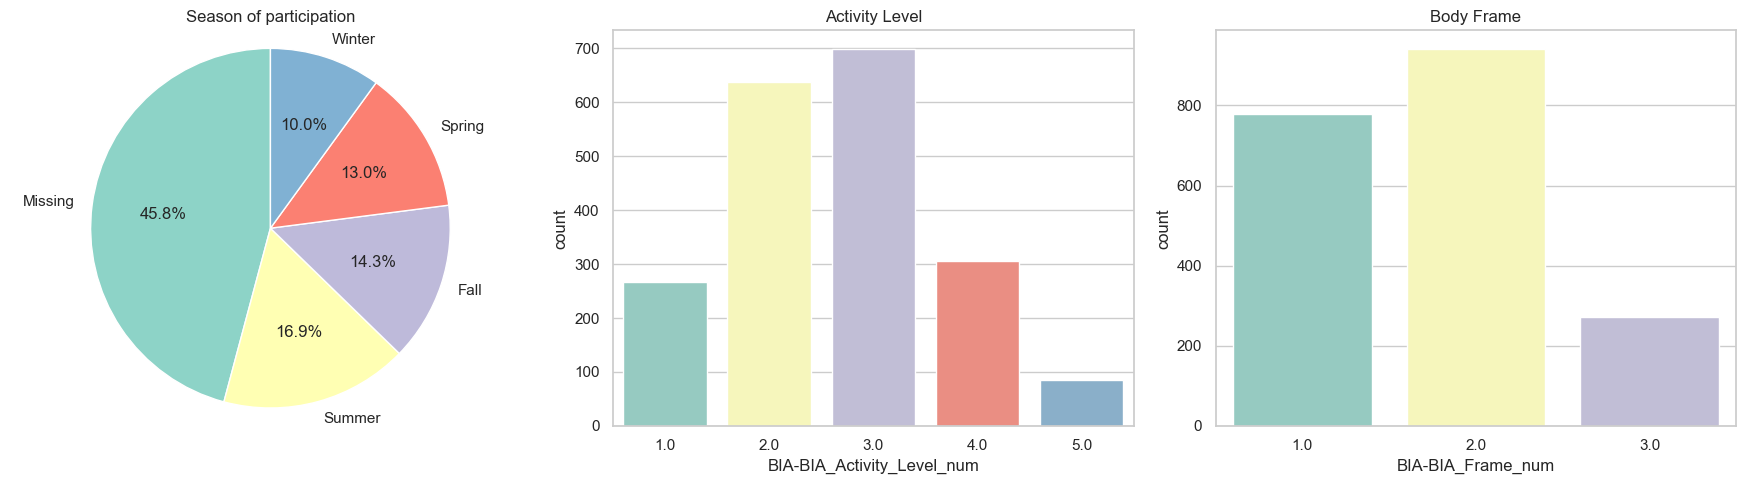

In [385]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Season
season_counts = train['BIA-Season'].value_counts(normalize=True)
axes[0].pie(
    season_counts, 
    labels=season_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=sns.color_palette("Set3")
)
axes[0].set_title(
    f"{bia_data_dict[bia_data_dict['Field'] == 'BIA-Season']['Description'].values[0]}"
)
axes[0].axis('equal')

# Other categorical columns
for idx, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=train, palette="Set3", ax=axes[idx+1])
    axes[idx+1].set_title(data_dict[data_dict['Field'] == col]['Description'].values[0])

plt.tight_layout()
plt.show()

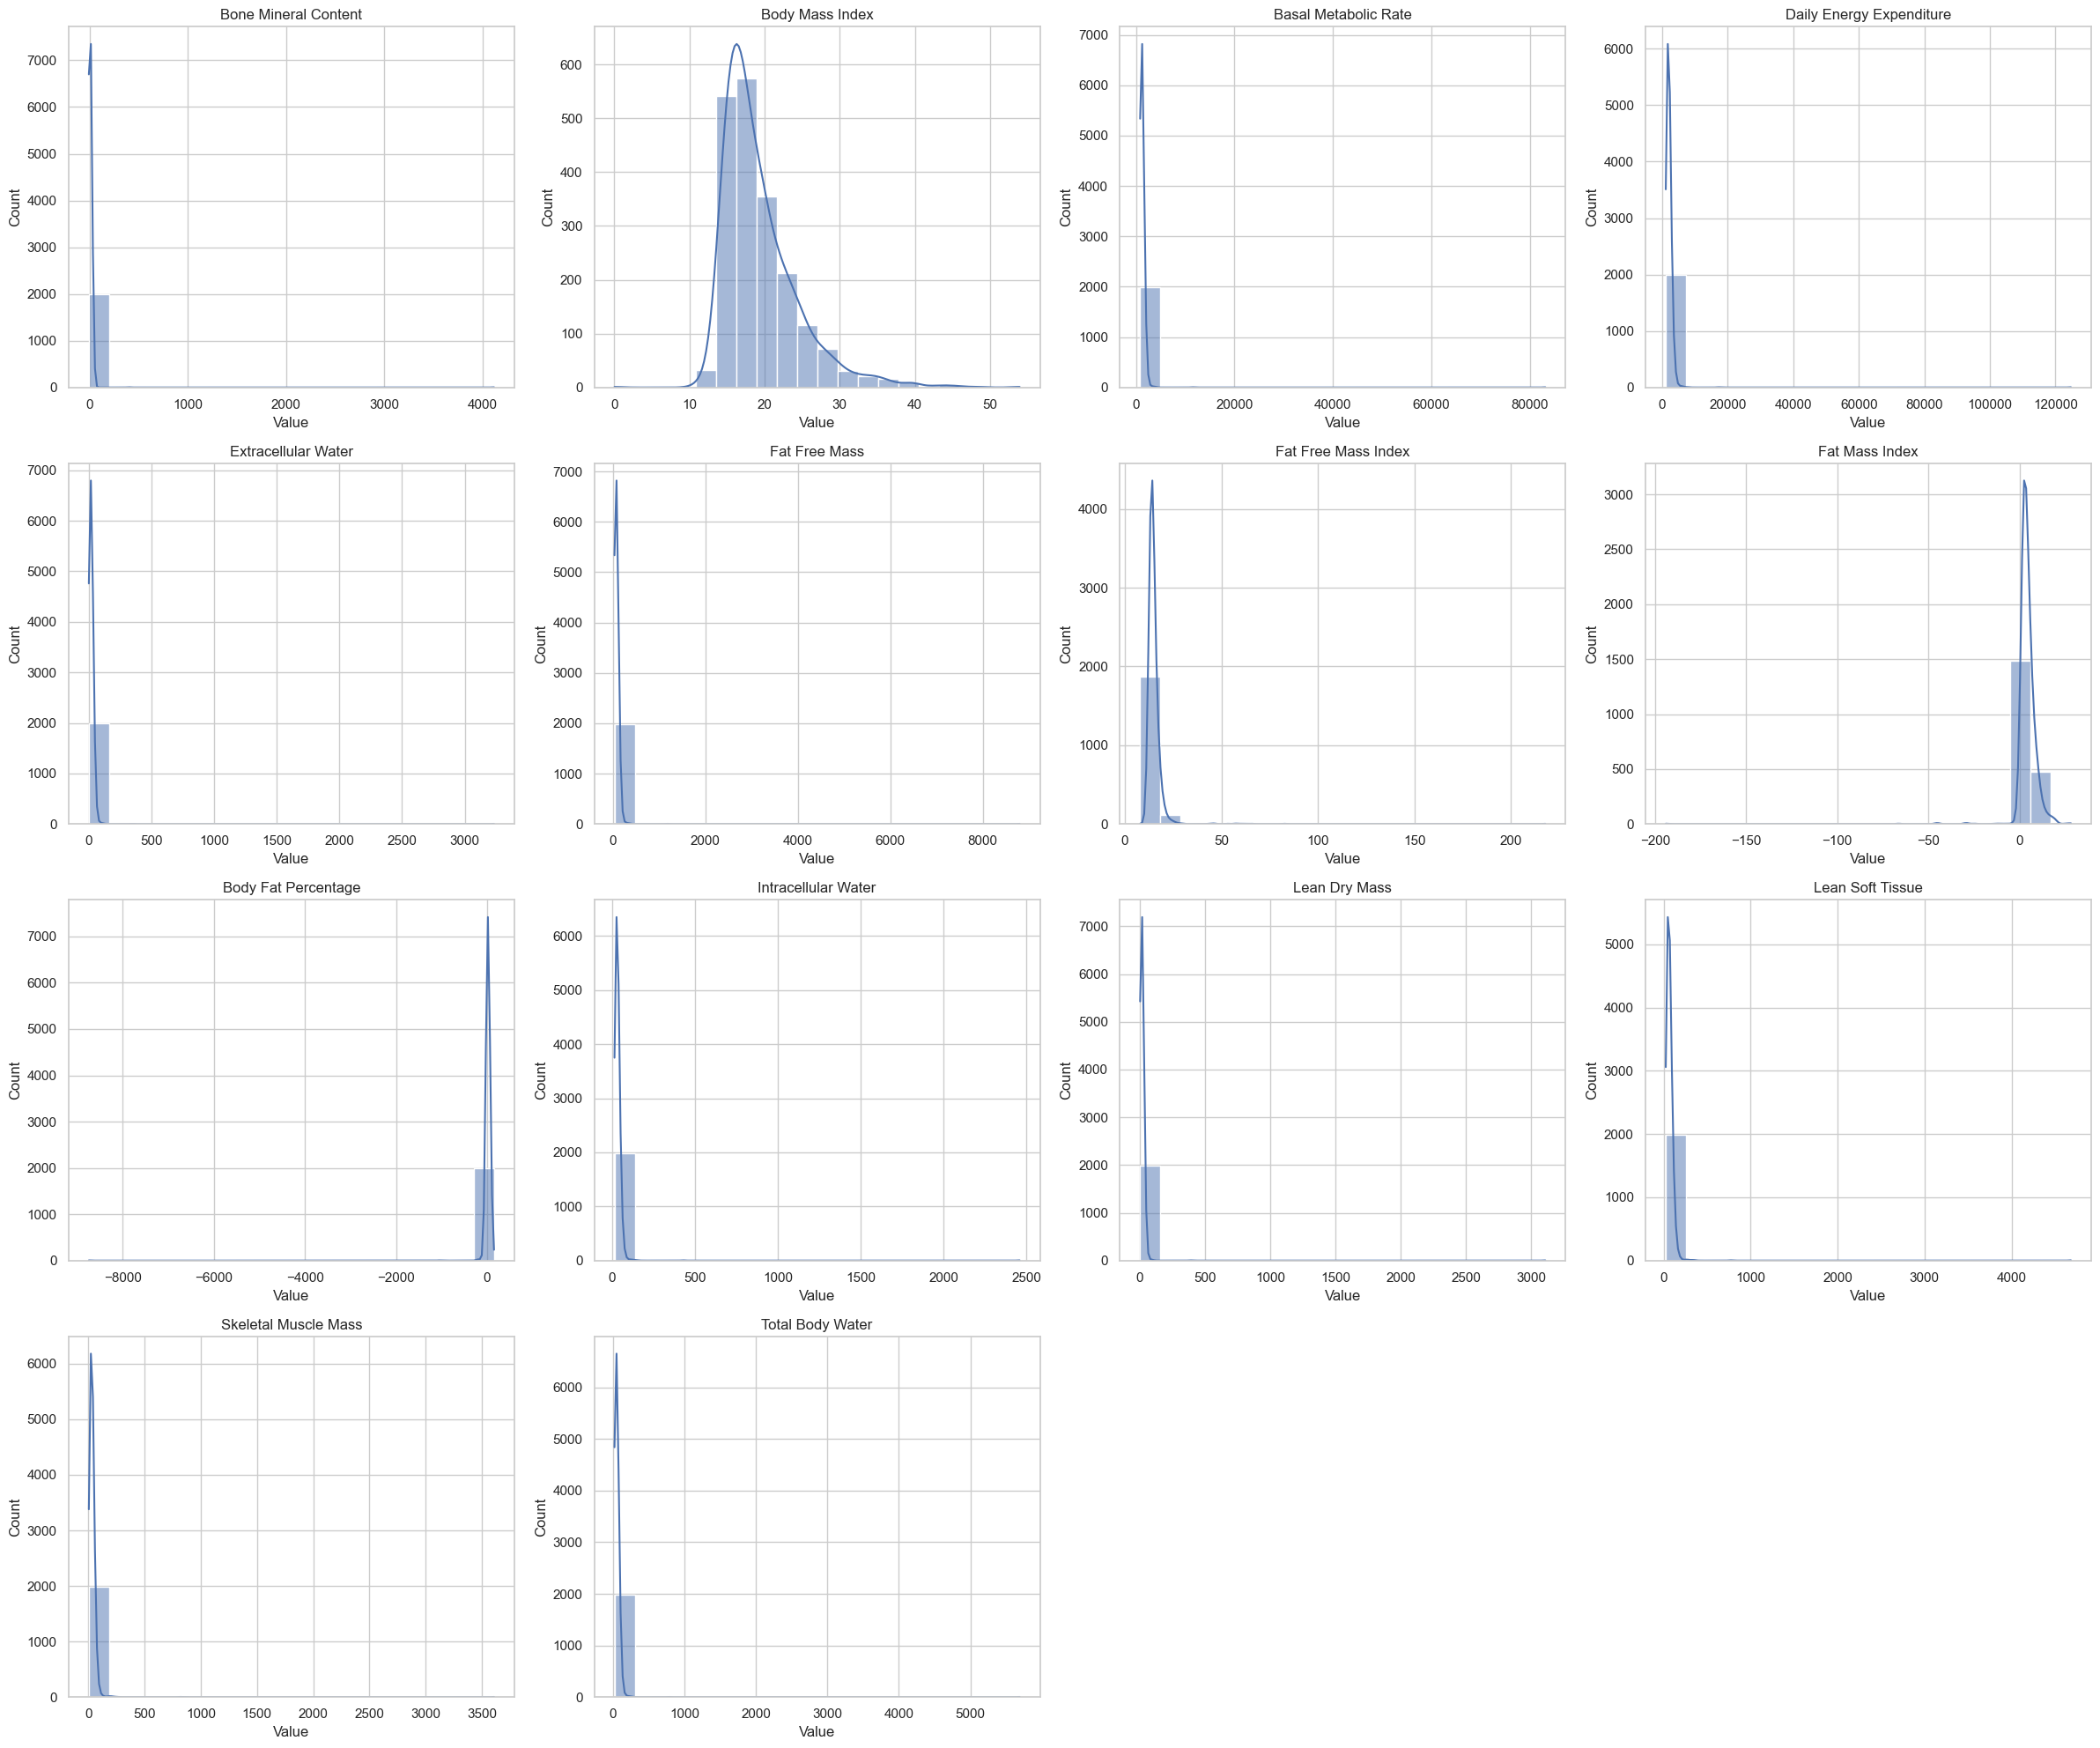

In [386]:
plt.figure(figsize=(24, 20))

for idx, col in enumerate(continuous_columns):
    plt.subplot(4, 4, idx + 1)
    sns.histplot(train[col].dropna(), bins=20, kde=True)
    plt.title(data_dict[data_dict['Field'] == col]['Description'].values[0])
    plt.xlabel('Value')

plt.tight_layout()
plt.show()

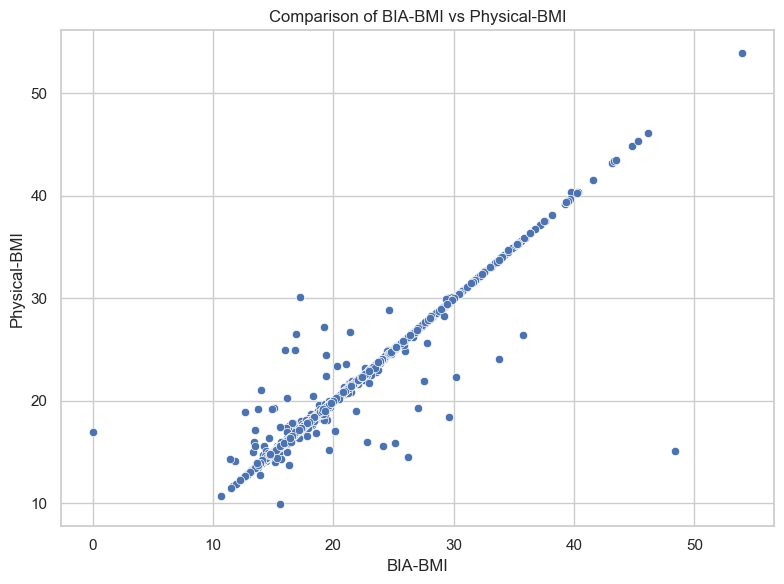

In [387]:
bmi_data = train[['BIA-BIA_BMI', 'Physical-BMI']].dropna()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='BIA-BIA_BMI', y='Physical-BMI',
    data=bmi_data,
    color='b'
)
plt.title('Comparison of BIA-BMI vs Physical-BMI')
plt.xlabel('BIA-BMI')
plt.ylabel('Physical-BMI')

plt.tight_layout()
plt.show()

In [388]:
bmi_measures = train[['BIA-Season', 'Physical-Season']].dropna()
bmi_measures.groupby(['BIA-Season', 'Physical-Season']).size().reset_index(name='Count')

,BIA-Season,Physical-Season,Count
0,Fall,Fall,407
1,Fall,Missing,6
2,Fall,Spring,15
3,Fall,Summer,131
4,Fall,Winter,8
5,Missing,Fall,294
6,Missing,Missing,635
7,Missing,Spring,309
8,Missing,Summer,277
9,Missing,Winter,300


In [389]:
groups.get('FitnessGram Vitals and Treadmill', [])

['Fitness_Endurance-Season',
 'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins',
 'Fitness_Endurance-Time_Sec']

In [390]:
data = train[train['Fitness_Endurance-Max_Stage'].notnull()]
train['Fitness_Endurance-Season'].value_counts(normalize=True)

Fitness_Endurance-Season
Missing    0.669697
Spring     0.097222
Winter     0.085354
Fall       0.083838
Summer     0.063889
Name: proportion, dtype: float64

In [391]:
cols = [
    'Fitness_Endurance-Max_Stage',
    'Fitness_Endurance-Time_Mins',
    'Fitness_Endurance-Time_Sec'
]

train[
    (train['Fitness_Endurance-Max_Stage'].notna()) & 
    (train['Fitness_Endurance-Time_Mins'].isna() | 
     train['Fitness_Endurance-Time_Sec'].isna())
][cols]

,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec
420,4.0,6.0,NaN
1470,26.0,NaN,NaN
2907,1.0,NaN,26.0
3666,2.0,NaN,NaN


In [392]:
train.loc[
    (train['Fitness_Endurance-Max_Stage'].notna()) & 
    (train['Fitness_Endurance-Time_Mins'].isna() | 
     train['Fitness_Endurance-Time_Sec'].isna()), cols
] = np.nan

In [393]:
train['Fitness_Endurance-Total_Time_Sec'] = train[
    'Fitness_Endurance-Time_Mins'
] * 60 + train['Fitness_Endurance-Time_Sec']

In [394]:
calculate_stats(train, ['Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Total_Time_Sec'])

,count,mean,std,min,25%,50%,75%,max,missing
Fitness_Endurance-Max_Stage,739.0,4.971583,1.856069,0.0,4.0,5.0,6.0,28.0,3221
Fitness_Endurance-Total_Time_Sec,739.0,469.910690,188.716073,5.0,362.0,476.0,590.5,1200.0,3221


In [395]:
data_dict[data_dict['Instrument'] == 'FitnessGram Child']

,Instrument,Field,Description,Type,Values,Value Labels
18,FitnessGram Child,FGC-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
19,FitnessGram Child,FGC-FGC_CU,Curl up total,int,NaN,NaN
20,FitnessGram Child,FGC-FGC_CU_Zone,Curl up fitness zone,categorical int,"0,1","0=Needs Improvement, 1=Healthy Fitness Zone"
21,FitnessGram Child,FGC-FGC_GSND,Grip Strength total (non-dominant),float,NaN,NaN
22,FitnessGram Child,FGC-FGC_GSND_Zone,Grip Strength fitness zone (non-dominant),categorical int,"1,2,3","1=Weak, 2=Normal, 3=Strong"
23,FitnessGram Child,FGC-FGC_GSD,Grip Strength total (dominant),float,NaN,NaN
24,FitnessGram Child,FGC-FGC_GSD_Zone,Grip Strength fitness zone (dominant),categorical int,"1,2,3","1=Weak, 2=Normal, 3=Strong"
25,FitnessGram Child,FGC-FGC_PU,Push-up total,int,NaN,NaN
26,FitnessGram Child,FGC-FGC_PU_Zone,Push-up fitness zone,categorical int,"0,1","0=Needs Improvement, 1=Healthy Fitness Zone"
27,FitnessGram Child,FGC-FGC_SRL,Sit & Reach total (left side),float,NaN,NaN


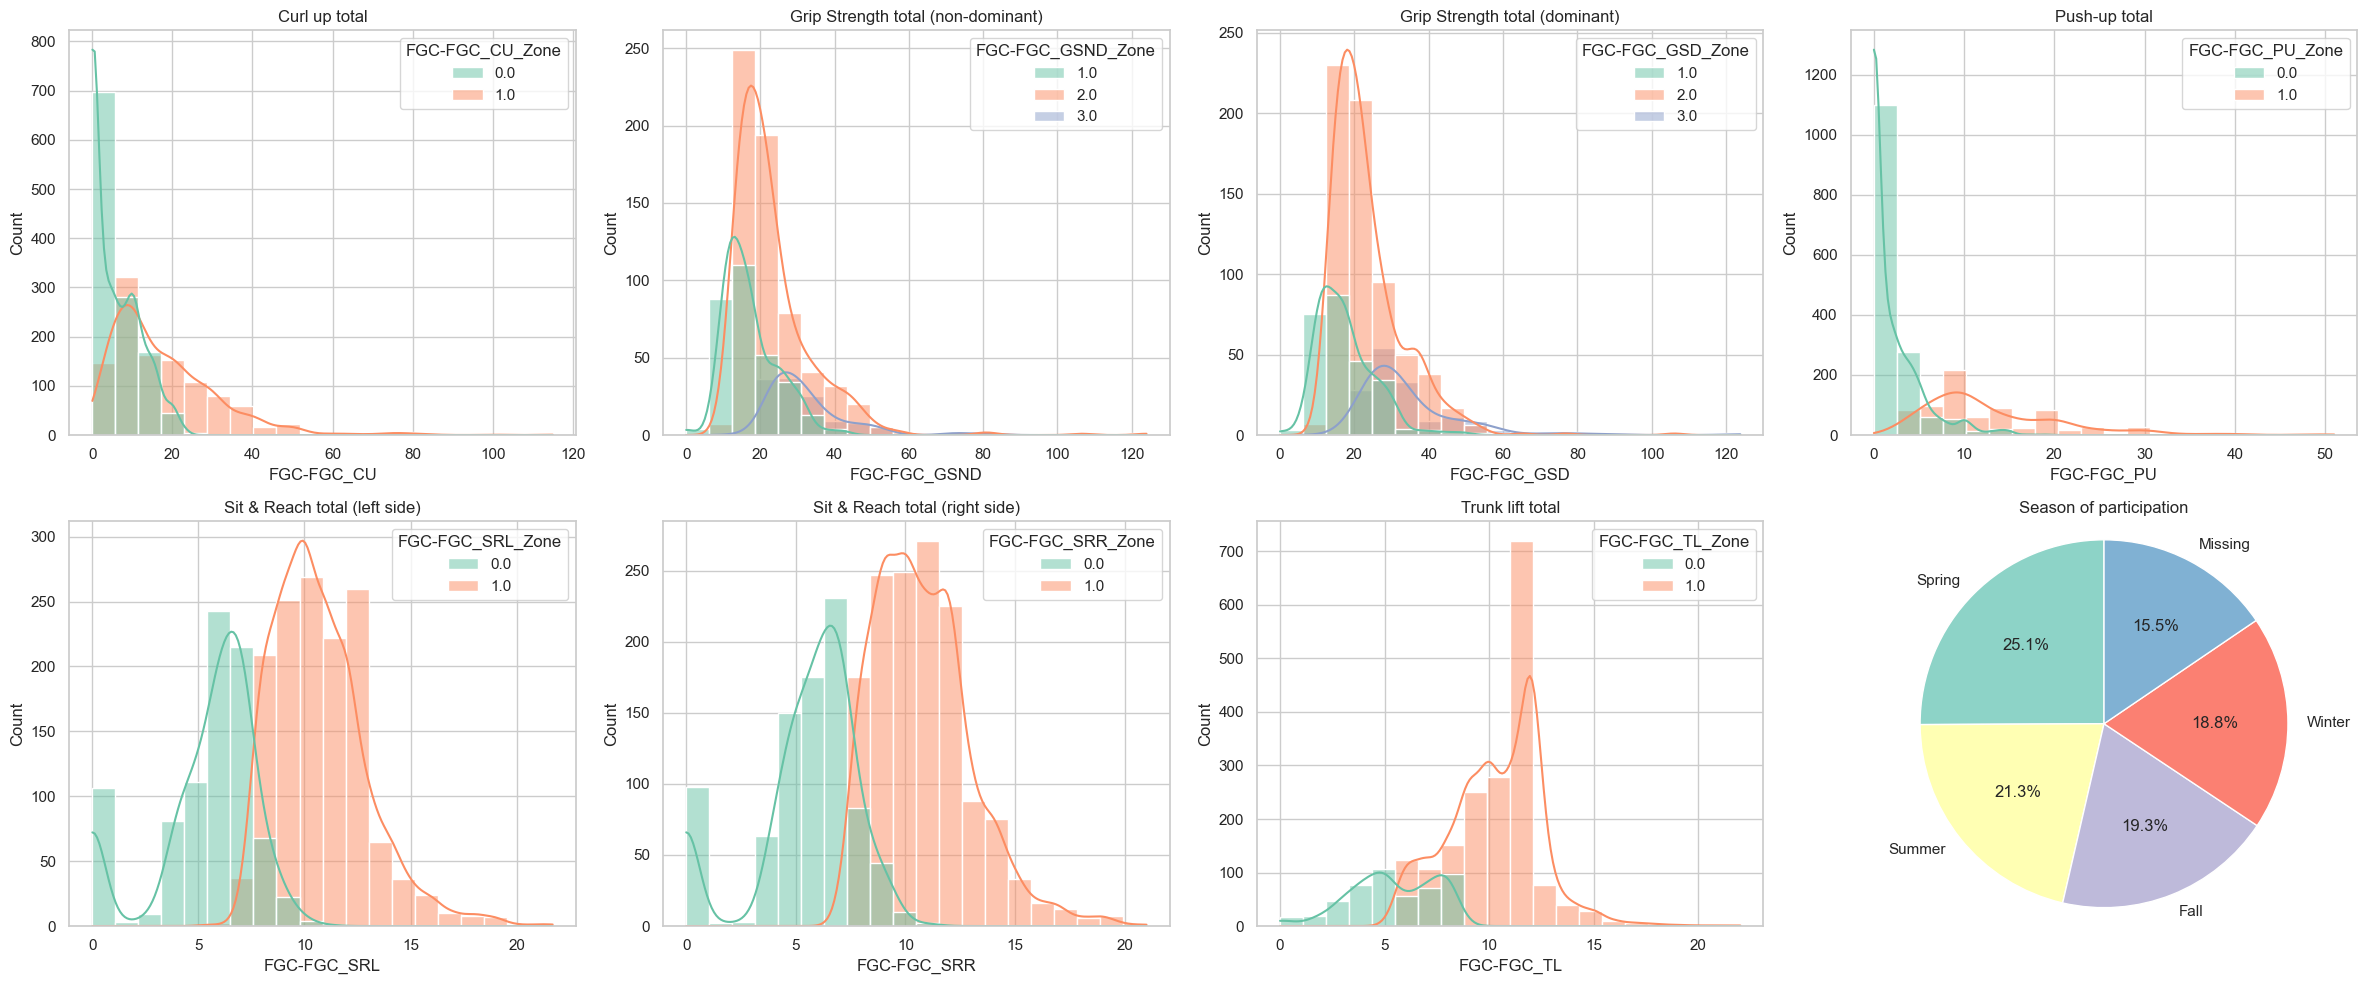

In [ ]:
fgc_data_dict = data_dict[data_dict['Instrument'] == 'FitnessGram Child']

fgc_columns = []

for index, row in fgc_data_dict.iterrows():
    if '_Zone' not in row['Field']:
        measure_field = row['Field']
        measure_desc = row['Description']
        
        zone_field = measure_field + '_Zone'
        zone_row = fgc_data_dict[fgc_data_dict['Field'] == zone_field]
        
        if not zone_row.empty:
            zone_desc = zone_row['Description'].values[0]
            fgc_columns.append((measure_field, zone_field, measure_desc, zone_desc))
            
fig, axes = plt.subplots(2, 4, figsize=(24, 10))

for idx, (measure, zone, measure_desc, zone_desc) in enumerate(fgc_columns):
    row = idx // 4
    col = idx % 4
    
    sns.histplot(
        data=train, x=measure,
        hue=zone, bins=20, palette='Set2',
        ax=axes[row, col], kde=True
    )
    axes[row, col].set_title(f'{measure_desc}')

season_counts = train['FGC-Season'].value_counts(normalize=True)
axes[1, 3].pie(
    season_counts, labels=season_counts.index,
    autopct='%1.1f%%', startangle=90,
    colors=sns.color_palette("Set3")
)
axes[1, 3].set_title('Season of participation')
axes[1, 3].axis('equal') 

plt.tight_layout()
plt.show()

In [397]:
measurement_columns = [measure for measure, _, _, _ in fgc_columns]
calculate_stats(train, measurement_columns)

,count,mean,std,min,25%,50%,75%,max,missing
FGC-FGC_CU,2322.0,11.259690,11.807781,0.0,3.0,9.00,15.750,115.0,1638
FGC-FGC_GSND,1074.0,22.420438,10.833995,0.0,15.1,20.05,26.600,124.0,2886
FGC-FGC_GSD,1074.0,23.518622,11.148951,0.0,16.2,21.20,28.175,123.8,2886
FGC-FGC_PU,2310.0,5.579654,7.390161,0.0,0.0,3.00,9.000,51.0,1650
FGC-FGC_SRL,2305.0,8.694924,3.429301,0.0,7.0,9.00,11.000,21.7,1655
FGC-FGC_SRR,2307.0,8.805635,3.422167,0.0,7.0,9.00,11.000,21.0,1653
FGC-FGC_TL,2324.0,9.252775,2.988863,0.0,7.0,10.00,12.000,22.0,1636


In [398]:
print(type(train))
def compute_min_max_by_sex(train, sex, fgc_columns):
    results = []
    
    for measure, zone, _, _ in fgc_columns:
        sorted_zones = sorted(train[zone].dropna().unique())
        for zone_value in sorted_zones:
            data = train[(train[zone] == zone_value) & 
                         (train['Basic_Demos-Sex'] == sex)][measure]
            
            if not data.empty:
                min_val, max_val = data.min(), data.max()
                results.append({
                    'Zone': int(zone_value),
                    'Measure': measure,
                    'Min-Max': f'{min_val} - {max_val}'
                })
    
    df = pd.DataFrame(results).pivot_table(
        index='Zone', columns='Measure', values='Min-Max', aggfunc='first'
    )
    
    return df

<class 'pandas.core.frame.DataFrame'>


In [399]:
compute_min_max_by_sex(train, 'Male', fgc_columns)

KeyError: 'Min-Max'

In [ ]:
compute_min_max_by_sex(train, 'Female', fgc_columns)

In [ ]:
results_male = []

for measure, zone, _, _ in fgc_columns:
    sorted_zones = sorted(train[zone].dropna().unique())
    for zone_value in sorted_zones:
        age_sex_data_by_zone = train[train[zone] == zone_value][
            ['Basic_Demos-Age', 'Basic_Demos-Sex', measure]
        ]
        unique_ages = age_sex_data_by_zone['Basic_Demos-Age'].dropna().unique()

        for age in sorted(unique_ages):
            age_sex_data = age_sex_data_by_zone[
                (age_sex_data_by_zone['Basic_Demos-Age'] == age) &
                (age_sex_data_by_zone['Basic_Demos-Sex'] == 'Male')
            ][measure]
            
            if not age_sex_data.empty:
                min_val, max_val = age_sex_data.min(), age_sex_data.max()
                results_male.append({
                    'Age': age,
                    'Sex': 'Male',
                    'Zone': zone_value,
                    'Measure': measure,
                    'Min-Max': f'{min_val} - {max_val}'
                })

df_male = pd.DataFrame(results_male).pivot_table(
    index=['Age', 'Sex', 'Zone'], columns='Measure', values='Min-Max', aggfunc='first'
)

df_male

age_ranges = []

measurement_columns = [measure for measure, _, _, _ in fgc_columns]
for measure in measurement_columns:
    valid_rows = train[~train[measure].isna()]
    
    min_age = valid_rows['Basic_Demos-Age'].min()
    max_age = valid_rows['Basic_Demos-Age'].max()
    
    age_ranges.append({
        'Measurement': measure,
        'Min Age': min_age,
        'Max Age': max_age
    })

age_ranges_df = pd.DataFrame(age_ranges)
age_ranges_df

KeyError: 'Min-Max'

In [ ]:
cols = [col for col in train.columns if col.startswith('FGC-') 
        and 'Zone' not in col and 'Season' not in col]
cols.extend(['Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Total_Time_Sec'])

data_subset = train[cols + ['complete_resp_total']]


In [ ]:
age_groups = train['Age Group'].unique()
train[
    (train['Age Group'] == 'Adults (19-22)') &
    (train['complete_resp_total'].notna()) &
    (train[cols].notna().any(axis=1))
][cols + ['complete_resp_total', 'Basic_Demos-Age']]

,FGC-FGC_CU,FGC-FGC_GSND,FGC-FGC_GSD,FGC-FGC_PU,FGC-FGC_SRL,FGC-FGC_SRR,FGC-FGC_TL,Fitness_Endurance-Max_Stage,Fitness_Endurance-Total_Time_Sec,complete_resp_total,Basic_Demos-Age
1483,34.0,52.5,56.8,17.0,13.0,12.0,6.0,NaN,NaN,1.0,20


In [ ]:
data = train[train['SDS-SDS_Total_Raw'].notnull()]
sds_season_counts = train['SDS-Season'].value_counts(normalize=True)

In [ ]:
data = train[train['PAQ_A-PAQ_A_Total'].notnull()]
train['PAQ_A-Season'].value_counts(normalize=True)
train['PAQ_C-Season'].value_counts(normalize=True)

paq_columns = [col for col in train.columns if 'PAQ' in col]
train[(train['PAQ_A-PAQ_A_Total'].notnull()) &
      (train['PAQ_C-PAQ_C_Total'].notnull())][
    paq_columns + ['Basic_Demos-Age']
]

,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,Basic_Demos-Age
3331,Summer,2.27,Spring,2.32,13
